<a href="https://colab.research.google.com/github/chetan-parthiban/MSSP608/blob/master/Lectures/Day3_CrossValidation_Hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import calendar
from scipy import stats
from matplotlib import dates
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Downloading and Preprocessing the Data (Same as in Days 1/2)

If you understand this part of the Day 1 and Day 2 notebooks, then feel free to skip over reading this part of the notebook since it is exactly the same. 

In [0]:
# Download the data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ' -O bikeshare_train.csv

--2020-01-21 23:19:33--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ
Resolving docs.google.com (docs.google.com)... 74.125.20.102, 74.125.20.100, 74.125.20.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3bau92p1uve88hhmhdef5pqm81qkga6b/1579644000000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download [following]
--2020-01-21 23:19:34--  https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3bau92p1uve88hhmhdef5pqm81qkga6b/1579644000000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download
Resolving doc-0s-5c-docs.googleusercontent.com (doc-0s-5c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0

In [0]:
bikeshare = pd.read_csv("bikeshare_train.csv")
bikeshare["date_objs"] = bikeshare["datetime"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
bikeshare["hour"] = bikeshare["date_objs"].apply(lambda x: x.hour)
bikeshare["day"] = bikeshare["date_objs"].apply(lambda x: x.day)
bikeshare["month"] = bikeshare["date_objs"].apply(lambda x: x.month)
bikeshare["year"] = bikeshare["date_objs"].apply(lambda x: x.year)
bikeshare["weekday"] = bikeshare["date_objs"].apply(lambda x: x.weekday())
bikeshare["plot_time"] = bikeshare["datetime"].apply(dates.datestr2num)

bikeshare["month_str"] = bikeshare["month"].apply(lambda x: calendar.month_name[x])
bikeshare["weekday_str"] = bikeshare["weekday"].apply(lambda x: calendar.day_name[x])
bikeshare["high_traffic"] = bikeshare["count"] > 145

def weather_norm(x):
    if x == 1:
        return "clear"
    if x == 2:
        return "overcast"
    if x > 2:
        return "gross"
    
bikeshare["weather_norm"] = bikeshare["weather"].apply(weather_norm)
print(bikeshare["weather_norm"].value_counts())
bikeshare.head()

clear       7192
overcast    2834
gross        860
Name: weather_norm, dtype: int64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date_objs,hour,day,month,year,weekday,plot_time,month_str,weekday_str,high_traffic,weather_norm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,0,1,1,2011,5,734138.000000,January,Saturday,False,clear
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,1,1,1,2011,5,734138.041667,January,Saturday,False,clear
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2,1,1,2011,5,734138.083333,January,Saturday,False,clear
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,3,1,1,2011,5,734138.125000,January,Saturday,False,clear
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,4,1,1,2011,5,734138.166667,January,Saturday,False,clear


# Cross-Validation

Here we'll move from having a single train-test split to instead having a single large training set that we split into folds to get multiple estimates of performance.

In [0]:
# Define a function that takes in the predictions of a classifier, the true labels,
# and a set of metrics and displays the model's performance on the metrics. This is
# very similar to the function we used in the Day 2 notebook!

def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Metrics
    conf_matrix = confusion_matrix(y_actual, y_pred)
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

Decision Tree: Fold 0 Results


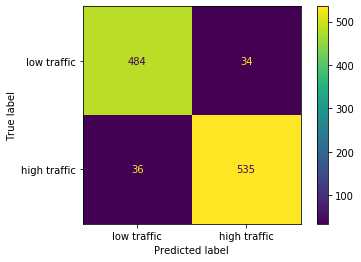

{'Accuracy': 93.5720844811754, 'Kappa': 0.8711595471738932, 'Precision': 0.9402460456942003, 'Recall': 0.9369527145359019}
------------------------
Decision Tree: Fold 1 Results


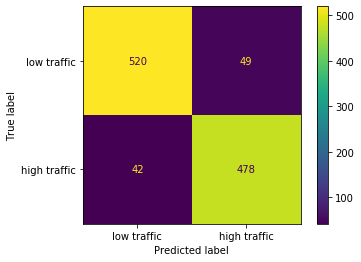

{'Accuracy': 91.643709825528, 'Kappa': 0.8326321602829238, 'Precision': 0.9070208728652751, 'Recall': 0.9192307692307692}
------------------------
Decision Tree: Fold 2 Results


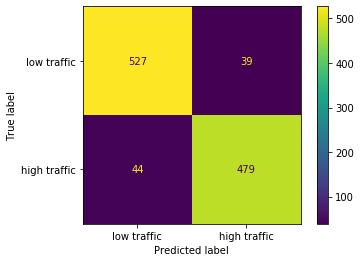

{'Accuracy': 92.3783287419651, 'Kappa': 0.8472730775014743, 'Precision': 0.9247104247104247, 'Recall': 0.9158699808795411}
------------------------
Decision Tree: Fold 3 Results


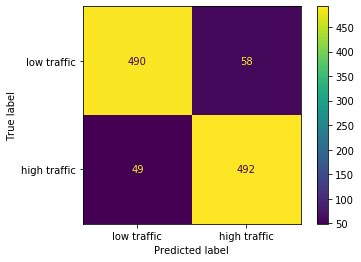

{'Accuracy': 90.17447199265382, 'Kappa': 0.8035021981487321, 'Precision': 0.8945454545454545, 'Recall': 0.9094269870609981}
------------------------
Decision Tree: Fold 4 Results


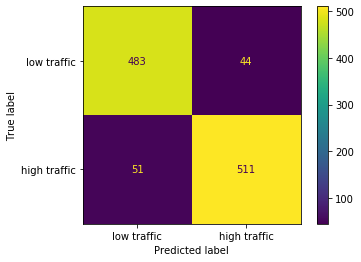

{'Accuracy': 91.27640036730946, 'Kappa': 0.8254198075238823, 'Precision': 0.9207207207207208, 'Recall': 0.9092526690391459}
------------------------
Decision Tree: Fold 5 Results


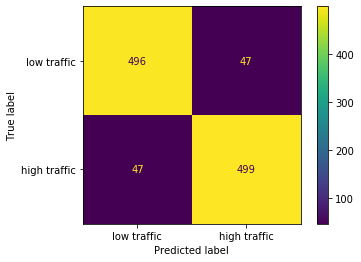

{'Accuracy': 91.3682277318641, 'Kappa': 0.8273632444903163, 'Precision': 0.9139194139194139, 'Recall': 0.9139194139194139}
------------------------
Decision Tree: Fold 6 Results


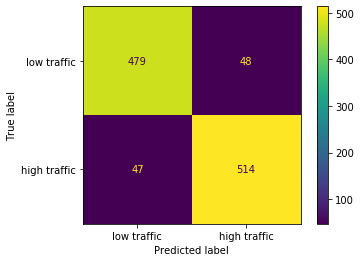

{'Accuracy': 91.26838235294117, 'Kappa': 0.8251868890166763, 'Precision': 0.9145907473309609, 'Recall': 0.9162210338680927}
------------------------
Decision Tree: Fold 7 Results


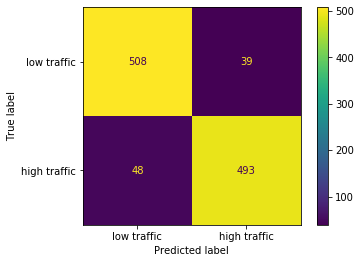

{'Accuracy': 92.00367647058823, 'Kappa': 0.8400540723217302, 'Precision': 0.9266917293233082, 'Recall': 0.911275415896488}
------------------------
Decision Tree: Fold 8 Results


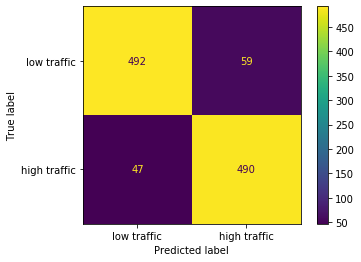

{'Accuracy': 90.25735294117648, 'Kappa': 0.8051701011247724, 'Precision': 0.8925318761384335, 'Recall': 0.9124767225325885}
------------------------
Decision Tree: Fold 9 Results


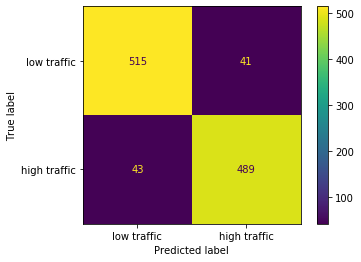

{'Accuracy': 92.27941176470588, 'Kappa': 0.8455005274404264, 'Precision': 0.9226415094339623, 'Recall': 0.9191729323308271}
------------------------
Mean Decision Tree Accuracy: 91.62220466699077
------------------------
Logistic Regression: Fold 0 Results


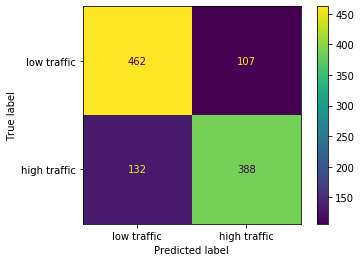

{'Accuracy': 78.0532598714417, 'Kappa': 0.5592623637887678, 'Precision': 0.7838383838383839, 'Recall': 0.7461538461538462}
------------------------
Logistic Regression: Fold 1 Results


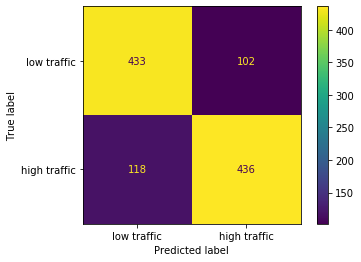

{'Accuracy': 79.7979797979798, 'Kappa': 0.5960437307362869, 'Precision': 0.8104089219330854, 'Recall': 0.7870036101083032}
------------------------
Logistic Regression: Fold 2 Results


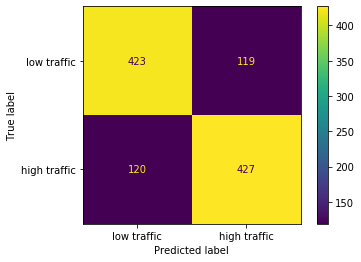

{'Accuracy': 78.0532598714417, 'Kappa': 0.56105964553683, 'Precision': 0.782051282051282, 'Recall': 0.7806215722120659}
------------------------
Logistic Regression: Fold 3 Results


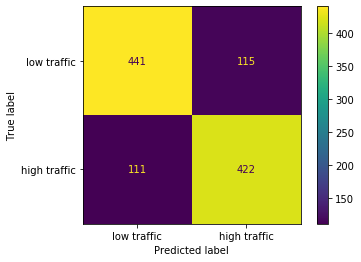

{'Accuracy': 79.24701561065197, 'Kappa': 0.5848195307597319, 'Precision': 0.7858472998137802, 'Recall': 0.7917448405253283}
------------------------
Logistic Regression: Fold 4 Results


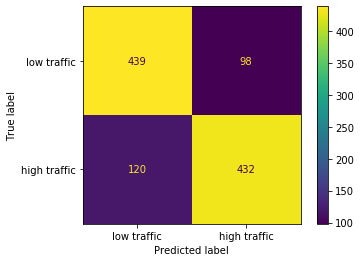

{'Accuracy': 79.98163452708907, 'Kappa': 0.5997794928335172, 'Precision': 0.8150943396226416, 'Recall': 0.782608695652174}
------------------------
Logistic Regression: Fold 5 Results


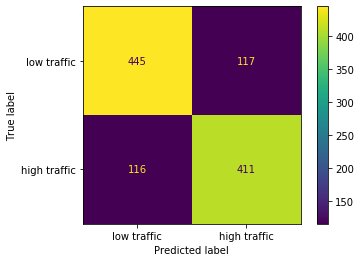

{'Accuracy': 78.60422405876952, 'Kappa': 0.5716673165840344, 'Precision': 0.7784090909090909, 'Recall': 0.7798861480075902}
------------------------
Logistic Regression: Fold 6 Results


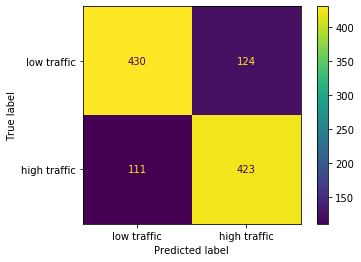

{'Accuracy': 78.40073529411765, 'Kappa': 0.5680584932053006, 'Precision': 0.773308957952468, 'Recall': 0.7921348314606742}
------------------------
Logistic Regression: Fold 7 Results


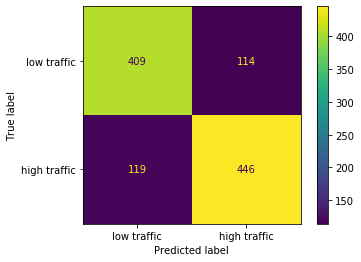

{'Accuracy': 78.58455882352942, 'Kappa': 0.5712043301759133, 'Precision': 0.7964285714285714, 'Recall': 0.7893805309734513}
------------------------
Logistic Regression: Fold 8 Results


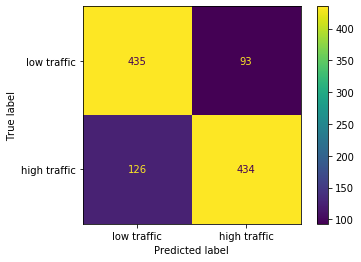

{'Accuracy': 79.87132352941177, 'Kappa': 0.5977961432506886, 'Precision': 0.8235294117647058, 'Recall': 0.775}
------------------------
Logistic Regression: Fold 9 Results


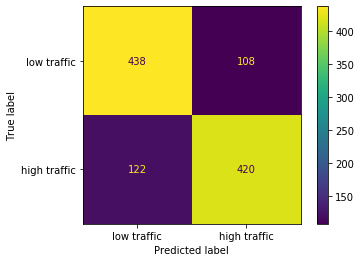

{'Accuracy': 78.86029411764706, 'Kappa': 0.5771601600519087, 'Precision': 0.7954545454545454, 'Recall': 0.7749077490774908}
------------------------
Mean Logistic Regression Accuracy: 78.94542855020795
------------------------
Best classifier is: Decision Tree 
With: 91.6% accuracy.


In [0]:
# Pick Classifiers to Compare
classifiers = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", multi_class='ovr', max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick Features to Use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Set up our dataset and cross validation split
X = bikeshare.loc[:, feature_set]
X = pd.get_dummies(X)
y = bikeshare["high_traffic"]
kf = KFold(n_splits=10, shuffle=True)

# Initialize variables to store results
best = 0
best_name = None

classifier_comparison = {}

# Compute and compare metrics for all classifiers
for classifier_name, classifier in classifiers.items():

    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate Model
        model = classifier.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

        # Display Results
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, ["low traffic", "high traffic"]).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")
    
    # Compute the average result for the metric we are optimizing over
    optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])
    
    # Update our tracking variables
    classifier_comparison[classifier_name] = all_fold_metrics
    
    if optimization_metric_avg > best:
        best = optimization_metric_avg
        best_name = classifier_name
    
    # Display Results
    print(f"Mean {classifier_name} {metric_to_optimize}: {optimization_metric_avg}")
    print("------------------------")

# Display our final result
print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.")    

## Rewriting Our Comparisons as a Function
We can also move this whole functionality into a function so we can call it in the future, moving the exact number of folds to a parameter in the function call.

In [0]:
"""
Options for noisy: "loud", "quiet", and other. Any other value prints nothing (silent).
"""

# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud'):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet':
        print(f"{classifier_name}: Fold {fold_num}")
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, ["low traffic", "high traffic"]).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Then define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud'):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

# Then define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud'):
    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = KFold(n_splits=folds, shuffle=shuffle)

    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': print(f"Average {classifier_name} {metric_to_optimize}: {optimization_metric_avg}")
    # Return our results
    return best, best_name, classifier_comparison
    

In [0]:
# Pick Classifiers to Compare
classifiers = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", multi_class='ovr', max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bikeshare, feature_set, "high_traffic", noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.")    

Decision Tree: Fold 0
Decision Tree: Fold 1
Decision Tree: Fold 2
Decision Tree: Fold 3
Decision Tree: Fold 4
Decision Tree: Fold 5
Decision Tree: Fold 6
Decision Tree: Fold 7
Decision Tree: Fold 8
Decision Tree: Fold 9
Average Decision Tree Accuracy: 91.35577870955547
Logistic Regression: Fold 0
Logistic Regression: Fold 1
Logistic Regression: Fold 2
Logistic Regression: Fold 3
Logistic Regression: Fold 4
Logistic Regression: Fold 5
Logistic Regression: Fold 6
Logistic Regression: Fold 7
Logistic Regression: Fold 8
Logistic Regression: Fold 9
Average Logistic Regression Accuracy: 78.9361023334954
Best classifier is: Decision Tree 
With: 91.4% accuracy.


## Plotting variation in performance, by fold

We can use visualization to see just how much of our performance is likely coming from random variation in which instances landed in our test set, instead of real variation in the accuracy of the classifier.

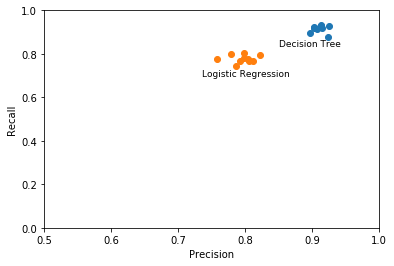

In [0]:
# Set Up Plotting
plt.xlim(0.5,1)
plt.xlabel("Precision")
plt.ylim(0,1)
plt.ylabel("Recall")

# Plot Data
for classifier in classifier_comparison:
    x = classifier_comparison[classifier]["Precision"]
    y = classifier_comparison[classifier]["Recall"]
    plt.scatter(x, y)
    plt.text(np.mean(x)-.06, np.mean(y)-.08, classifier, fontsize=9)

## Statistical significance of differences in cross-validation

Testing differences between models gets a lot easier than working with once we have multiple estimates! Now we have genuine paired comparisons and we can run a simple t-test on the resulting data from each fold.

In [0]:
metric_to_compare = "Accuracy"
trees_results = classifier_comparison["Decision Tree"][metric_to_compare]
regression_results = classifier_comparison["Logistic Regression"][metric_to_compare]

trees_mean = np.mean(trees_results)
regression_mean = np.mean(regression_results)
t, p = stats.ttest_rel(trees_results, regression_results)

print(f"Is {trees_mean:.3f} statistically different than {regression_mean:.3f}?")
if p < 0.01:
    print("Yes", end=', ')
else:
    print("No", end=', ')
print(f"t={t:.3f}, p={p:.4f}")


Is 91.356 statistically different than 78.936?
Yes, t=24.018, p=0.0000


## The impact of small data

So far we've been working on a single dataset at a time, mostly fixed in place. By introducing cross-validation we show that different, equally-sized sets of similar data can produce different results. But often in a real-world context we'll find that _gathering_ the data in the first place is part of our job (we'll cover this more in weekend 2). 

One thing we might want to know is just how fast our learning rate is improving as we add more and more data. Crucially, we're also going to have to answer a key question: How much data do we need?

In [0]:
def evaluate_overfitting(df, min_split, noisy=True):

    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df["high_traffic"]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

    model = DecisionTreeClassifier(criterion="entropy", min_samples_split=min_split, random_state=123).fit(X_train, y_train)

    overfit_pred = model.predict(X_train)
    overfit_accuracy = 100*accuracy_score(y_train, overfit_pred)
    y_pred = model.predict(X_test)
    accuracy = 100*accuracy_score(y_test, y_pred)
    tree_size = model.get_n_leaves()

    if noisy:
        print(f"   Training Accuracy: {overfit_accuracy:.1f}%")
        print(f"   Testing Accuracy: {accuracy:.1f}%")
        print(f"   Tree contains {tree_size} leaves")

    return tree_size, accuracy, overfit_accuracy

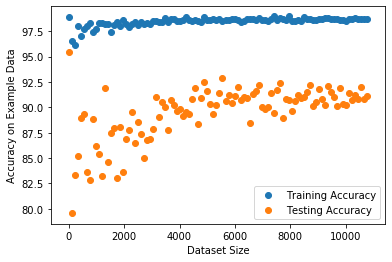

In [0]:
accuracies = []
overfit_accuracies = []

# For different Sized Data sets
for i in range(100):
    bikeshare_small = bikeshare.iloc[bikeshare.index % 100 <= i]
    # Evaluate and store how much the tree overfits
    tree_size, accuracy, overfit_accuracy = evaluate_overfitting(bikeshare_small, 5, noisy=False)
    accuracies.append(accuracy)
    overfit_accuracies.append(overfit_accuracy)

# Plot the Results
ax = plt.gca()
x_index = [x * (len(bikeshare)/100) for x in range(100)]
ax.scatter(x_index, overfit_accuracies)
ax.scatter(x_index, accuracies)
plt.ylabel("Accuracy on Example Data")
plt.xlabel("Dataset Size")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

# Hyperparameters

## Why tune hyperparameters?

### Training/test differences grow as models get more complicated

One hyperparameter to tune, based on the quantity of data available and the homogeneity of your domain, is the complexity of the trees that you want to learn.

Here we'll show how a more and more complex tree doesn't necessarily result in generalization to new data that we've never seen before, even as performance improves.

In [0]:
feature_set = date_features + time_features + weather_features
 
for minimum in [2, 5, 10, 50, 100]:
    evaluate_overfitting(bikeshare, minimum)

   Training Accuracy: 100.0%
   Testing Accuracy: 90.7%
   Tree contains 642 leaves
   Training Accuracy: 98.7%
   Testing Accuracy: 91.1%
   Tree contains 526 leaves
   Training Accuracy: 97.2%
   Testing Accuracy: 91.0%
   Tree contains 399 leaves
   Training Accuracy: 92.8%
   Testing Accuracy: 89.2%
   Tree contains 156 leaves
   Training Accuracy: 90.4%
   Testing Accuracy: 88.6%
   Tree contains 91 leaves


## Decision Tree Hyperparameters

In [0]:
# Parameters to tune:
# - Measurement of leaf purity (gini vs. information gain)
# - Size of splits (tree size)
# - Definition of purity

criteria = ["gini", "entropy"]

size_of_splits = range(2, 100, 2)

purity = [0, 0.0001, 0.001, 0.01, 0.1]

### Tuning size of splits

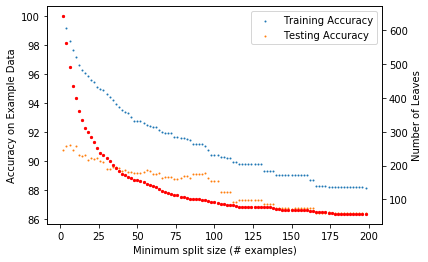

In [0]:
leaves = []
accuracies = []
overfit_accuracies = []
for i in range(2,200,2):
    tree_size, accuracy, overfit_accuracy = evaluate_overfitting(bikeshare, i, noisy=False)
    leaves.append(tree_size)
    accuracies.append(accuracy)
    overfit_accuracies.append(overfit_accuracy)
    
ax = plt.gca()
ax.scatter(range(2,200,2), overfit_accuracies, s=1)
ax.scatter(range(2,200,2), accuracies, s=1)

plt.ylabel("Accuracy on Example Data")
plt.xlabel("Minimum split size (# examples)")
plt.legend(["Training Accuracy", "Testing Accuracy"])

right_ax = ax.twinx()
right_ax.scatter(range(2,200,2), leaves, s=5, color="red")
plt.ylabel("Number of Leaves")
plt.show()

We see, then, that our most fine-grained model with 2-instance splits allowed gets us a model with over 600 leaves and 90% accuracy on testing data, but if we limit our tree drastically (for instance, to minimum split size between 50-100 instances), we see a reduction in accuracy as small as 1% while the model complexity drops down to only 100 leaves.

In [0]:
classifier_comparison = {}

best = 0
best_size = None

accuracies = []

for size in size_of_splits:
    classifier = DecisionTreeClassifier(criterion="entropy", min_samples_split=size, random_state=123)
    results = train_and_evaluate(classifier, bikeshare, feature_set, "high_traffic", folds=10, noisy="silent")
    accuracy = np.mean(results["accuracy"])
    kappa = np.mean(results["kappa"])
    accuracies.append(accuracy)
    print(f"Mean {size}: Accuracy {accuracy:.1f}%, K={kappa:.3f}")

    classifier_comparison[classifier_name] = results
    
    metric_to_optimize = accuracy

    if metric_to_optimize > best:
        best = metric_to_optimize
        best_name = size
    

    
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")    

Mean 2: Accuracy 91.8%, K=0.835
Mean 4: Accuracy 91.4%, K=0.828
Mean 6: Accuracy 91.4%, K=0.828
Mean 8: Accuracy 91.4%, K=0.828
Mean 10: Accuracy 91.5%, K=0.831
Mean 12: Accuracy 91.6%, K=0.832
Mean 14: Accuracy 91.6%, K=0.832
Mean 16: Accuracy 91.6%, K=0.832
Mean 18: Accuracy 91.7%, K=0.833
Mean 20: Accuracy 91.6%, K=0.832
Mean 22: Accuracy 91.5%, K=0.831
Mean 24: Accuracy 91.4%, K=0.829
Mean 26: Accuracy 91.5%, K=0.830
Mean 28: Accuracy 91.5%, K=0.829
Mean 30: Accuracy 91.3%, K=0.826
Mean 32: Accuracy 91.3%, K=0.825
Mean 34: Accuracy 91.2%, K=0.824
Mean 36: Accuracy 91.1%, K=0.822
Mean 38: Accuracy 91.0%, K=0.821
Mean 40: Accuracy 91.0%, K=0.820
Mean 42: Accuracy 90.7%, K=0.815
Mean 44: Accuracy 90.7%, K=0.814
Mean 46: Accuracy 90.6%, K=0.811
Mean 48: Accuracy 90.5%, K=0.809
Mean 50: Accuracy 90.3%, K=0.805
Mean 52: Accuracy 90.2%, K=0.804
Mean 54: Accuracy 90.2%, K=0.805
Mean 56: Accuracy 90.2%, K=0.804
Mean 58: Accuracy 90.2%, K=0.804
Mean 60: Accuracy 90.0%, K=0.800
Mean 62: Accur

Text(0, 0.5, 'Test set accuracy')

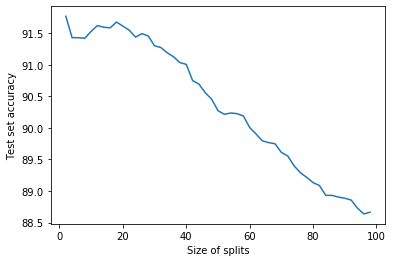

In [0]:
plt.plot(size_of_splits, accuracies)
plt.xlabel("Size of splits")
plt.ylabel("Test set accuracy")

### Tuning purity threshold

Mean 0: Accuracy 91.8%, K=0.835
Mean 0.0001: Accuracy 91.6%, K=0.831
Mean 0.001: Accuracy 90.3%, K=0.805
Mean 0.01: Accuracy 86.1%, K=0.722
Mean 0.1: Accuracy 77.3%, K=0.545
Best feature set is: 98 
With: 91.8% accuracy.


Text(0, 0.5, 'Test set accuracy')

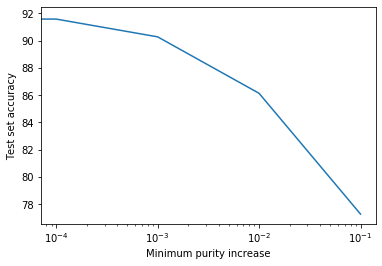

In [0]:
classifier_comparison = {}

best = 0
best_size = None

accuracies = []

for pur in purity:
    classifier = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=pur, random_state=123)
    results = train_and_evaluate(classifier, bikeshare, feature_set, "high_traffic", folds=10, noisy="silent")
    accuracy = np.mean(results["accuracy"])
    kappa = np.mean(results["kappa"])
    accuracies.append(accuracy)
    print(f"Mean {pur}: Accuracy {accuracy:.1f}%, K={kappa:.3f}")

    classifier_comparison[classifier_name] = results
    
    metric_to_optimize = accuracy

    if metric_to_optimize > best:
        best = metric_to_optimize
        best_name = size
    

print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")    

plt.plot(purity, accuracies)
plt.xlabel("Minimum purity increase")
plt.xscale("log")
plt.ylabel("Test set accuracy")

### Tuning purity criterion

In [0]:
criteria_comparison = {}

best = 0
best_size = None
best_crit = None

for crit in criteria:

    accuracies = []

    for size in size_of_splits:
        classifier = DecisionTreeClassifier(criterion=crit, min_samples_split=size, random_state=123)
        results = train_and_evaluate(classifier, bikeshare, feature_set, "high_traffic", folds=10, noisy="silent")
        accuracy = np.mean(results["accuracy"])
        kappa = np.mean(results["kappa"])
        accuracies.append(accuracy)
        print(f"Mean {size}: Accuracy {accuracy:.1f}%, K={kappa:.3f}")

        classifier_comparison[classifier_name] = results

        metric_to_optimize = accuracy

        if metric_to_optimize > best:
            best = metric_to_optimize
            best_size = size
            best_crit = crit
    
    criteria_comparison[crit] = accuracies
    
print(f"Best mix is: {best_crit} criterion, {best_size} size\nWith: {best:.1f}% accuracy.")    

Mean 2: Accuracy 90.9%, K=0.817
Mean 4: Accuracy 90.9%, K=0.818
Mean 6: Accuracy 91.2%, K=0.824
Mean 8: Accuracy 91.2%, K=0.823
Mean 10: Accuracy 91.3%, K=0.826
Mean 12: Accuracy 91.3%, K=0.826
Mean 14: Accuracy 91.2%, K=0.824
Mean 16: Accuracy 91.2%, K=0.823
Mean 18: Accuracy 91.0%, K=0.820
Mean 20: Accuracy 91.0%, K=0.820
Mean 22: Accuracy 91.0%, K=0.820
Mean 24: Accuracy 91.1%, K=0.821
Mean 26: Accuracy 91.0%, K=0.820
Mean 28: Accuracy 91.0%, K=0.819
Mean 30: Accuracy 90.9%, K=0.818
Mean 32: Accuracy 90.9%, K=0.819
Mean 34: Accuracy 90.9%, K=0.818
Mean 36: Accuracy 90.9%, K=0.817
Mean 38: Accuracy 90.8%, K=0.816
Mean 40: Accuracy 90.7%, K=0.814
Mean 42: Accuracy 90.7%, K=0.814
Mean 44: Accuracy 90.6%, K=0.811
Mean 46: Accuracy 90.4%, K=0.808
Mean 48: Accuracy 90.4%, K=0.808
Mean 50: Accuracy 90.4%, K=0.808
Mean 52: Accuracy 90.4%, K=0.807
Mean 54: Accuracy 90.4%, K=0.807
Mean 56: Accuracy 90.3%, K=0.806
Mean 58: Accuracy 90.2%, K=0.804
Mean 60: Accuracy 90.3%, K=0.806
Mean 62: Accur

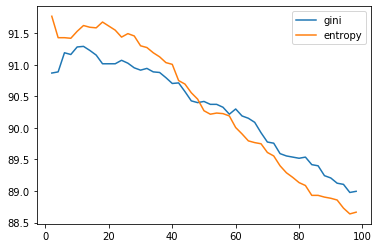

In [0]:
for crit in criteria_comparison.keys():
    plt.plot(size_of_splits, criteria_comparison[crit])

plt.legend(criteria_comparison.keys())

So on this dataset, it looks like we don't have a *lot* of tuning we can do with decision trees - the entropy criterion we started with is slightly better in performance compared to the gini criterion, and reducing the number of splits only starts hurting accuracy once you've really shrunk the tree. Interestingly, on his dataset the enropy criterion worsens faster than gini as the tree size gets smaller, meaning if we're looking for a reasonably accurate and small tree, gini may be the better choice. 

## Tuning Logistic Regression

In [0]:
cost_type = ["l1", "l2", "elasticnet", "none"]

elastic_net_mixes = np.arange(0,1,0.1)

strengths = [0.0001, 0.001, 0.01, 0.1, 1, 10]

print(elastic_net_mixes)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


### Tuning regularization strength

In [0]:

@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UndefinedMetricWarning)
def test_strengths(df, feature_set, strengths):
    best = 0
    best_strength = None
    strength_results = {
        "accuracy":[],
        "kappa":[]    
    }
    for strength in strengths:
        classifier = LogisticRegression(penalty="l1", C=strength, solver="saga", max_iter=1000, random_state=123)
        results = train_and_evaluate(classifier, df, feature_set, "high_traffic", folds=5, noisy="quiet")
        accuracy = np.mean(results["accuracy"])
        kappa = np.mean(results["kappa"])
        print(f"C={strength}: Accuracy {accuracy:.1f}%, K={kappa:.3f}")

        classifier_comparison[classifier_name] = results

        metric_to_optimize = accuracy

        if metric_to_optimize > best:
            best = metric_to_optimize
            best_strength = strength
        
        strength_results["accuracy"].append(accuracy)
        strength_results["kappa"].append(kappa)
    return best, best_strength, strength_results


best, best_strength, results = test_strengths(bikeshare, feature_set, strengths)
print(f"Best regularization strength is: C={best_strength}\nWith: {best:.1f}% accuracy.")    


Fold...0...1...2...3...4
C=0.0001: Accuracy 72.6%, K=0.452
Fold...0...1...2...3...4
C=0.001: Accuracy 76.4%, K=0.529
Fold...0...1...2...3...4
C=0.01: Accuracy 77.2%, K=0.544
Fold...0...1...2...3...4
C=0.1: Accuracy 77.4%, K=0.548
Fold...0...1...2...3...4
C=1: Accuracy 77.4%, K=0.548
Fold...0...1...2...3...4
C=10: Accuracy 77.4%, K=0.548
Best regularization strength is: C=1
With: 77.4% accuracy.


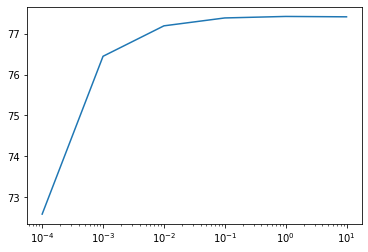

In [0]:
plt.plot(strengths, results["accuracy"])
plt.xscale("log")

In [0]:

@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UndefinedMetricWarning)
def test_mixes(df, feature_set, mixes):
    best = 0
    best_mix = None
    mix_results = {
        "accuracy":[],
        "kappa":[]    
    }
    for mix in mixes:
        classifier = LogisticRegression(penalty="elasticnet", C=1, l1_ratio=mix, solver="saga", max_iter=1000, random_state=123)
        results = train_and_evaluate(classifier, df, feature_set, "high_traffic", folds=5, noisy="quiet")
        accuracy = np.mean(results["accuracy"])
        kappa = np.mean(results["kappa"])
        print(f"Mix={mix}: Accuracy {accuracy:.1f}%, K={kappa:.3f}")

        classifier_comparison[classifier_name] = results

        metric_to_optimize = accuracy

        if metric_to_optimize > best:
            best = metric_to_optimize
            best_mix = mix
        
        mix_results["accuracy"].append(accuracy)
        mix_results["kappa"].append(kappa)
    return best, best_mix, mix_results


best, best_mix, results = test_mixes(bikeshare, feature_set, [0,0.5,1])
print(f"Best elastic net mix is: C={best_mix}\nWith: {best:.1f}% accuracy.")    

Fold...0...1...2...3...4
Mix=0: Accuracy 77.4%, K=0.548
Fold...0...1...2...3...4
Mix=0.5: Accuracy 77.4%, K=0.548
Fold...0...1...2...3...4
Mix=1: Accuracy 77.4%, K=0.548
Best elastic net mix is: C=0.5
With: 77.4% accuracy.


In [0]:
@ignore_warnings(category=ConvergenceWarning)
def get_tuned_results(df):
    classifier = LogisticRegression(penalty="elasticnet", C=1, l1_ratio=0.5, solver="saga", max_iter=1000, random_state=123)
    results = train_and_evaluate(classifier, df, feature_set, "high_traffic", folds=10, noisy="quiet")
    return results
    
results = get_tuned_results(bikeshare)

Fold...0...1...2...3...4...5...6...7...8...9


In [0]:
precisions = []
recalls = []

true_positive_rates = []
false_positive_rates = []

all_probabilities = []
all_actuals = []
for actual_labels in results["actual"]:
    all_actuals.extend(actual_labels)
for fold_probabilities in results["prediction_probabilities"]:
    probabilities = [x[1] for x in fold_probabilities]
    all_probabilities.extend(probabilities)
    
for threshold in np.arange(0, 0.99, 0.01):
    all_predictions = [x > threshold for x in all_probabilities]
    precision = precision_score(all_predictions, all_actuals, pos_label=True)
    recall = recall_score(all_predictions, all_actuals, pos_label=True)
    
    precisions.append(precision)
    recalls.append(recall)
    
    count_positives = np.sum([int(all_actuals[i] == True) for i in range(len(all_actuals))])
    count_negatives = np.sum([int(all_actuals[i] == False) for i in range(len(all_actuals))])
    
    true_positive = np.sum([all_predictions[i] == True and all_actuals[i] == True for i in range(len(all_predictions))])
    false_positive = np.sum([all_predictions[i] == True and all_actuals[i] == False for i in range(len(all_predictions))])

    true_positive_rates.append(true_positive / count_positives)
    false_positive_rates.append(false_positive / count_negatives)

Text(0, 0.5, 'Precision')

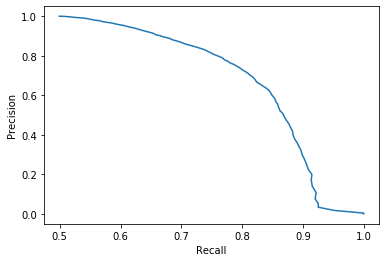

In [0]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")

Text(0, 0.5, 'True Positive Rate')

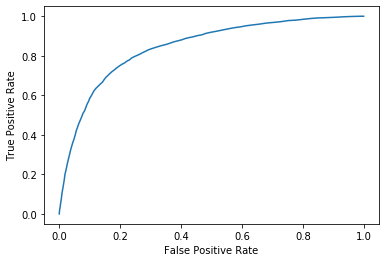

In [0]:
plt.plot(false_positive_rates, true_positive_rates)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

With these charts, we see that a single logistic regression actually gives us a fairly wide, flexible range of classifiers: 
   - We can build a model that has 20% false positives but correctly identifies around 80% of true positive cases.
   - Or we can build a model that successfully finds about 90% of true positives while filtering out about 50% of false cases.

By default the model will find a balance between the two metrics. But there might be value in this tuning for your application!

## Hyperparameter tuning with Scikit-learn

One of the key advantages of working in Python is that much of the unwieldy work we've been doing this weekend is built into the language by default. If all you're looking for is to train an optimal classifier with simple code, Scikit-learn has given us tools to get a lot done with built-in library tools. 

Here's a sample that sets aside a test set, does hyperparameter tuning within our training set using cross-validation, model quality reporting, and final training of the full training set using our best parameters all in one place.

In [0]:
hyperparameters = {
    "criterion":["gini", "entropy"],
    "min_impurity_decrease":[0, 0.0001, 0.001],
    "min_samples_split":range(2, 20, 2)
}
search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                            param_grid=hyperparameters, cv=5, scoring="accuracy")


date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features


X = bikeshare.loc[:, feature_set]
X = pd.get_dummies(X)

y = bikeshare["high_traffic"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123, shuffle=True)

classifier = search.fit(X_train, y_train)

y_predict = classifier.predict(X_test)


In [0]:
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

Best fit was DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')
With 91.3% accuracy.


In [0]:
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.1f}%")


Accuracy on held-out test set: 90.5%


In [0]:
classifier.cv_results_

{'mean_fit_time': array([0.02658906, 0.02345896, 0.02314739, 0.02273278, 0.02364998,
        0.02345018, 0.02268233, 0.02227693, 0.02266111, 0.02101493,
        0.02129669, 0.02083359, 0.02065067, 0.01980729, 0.0202497 ,
        0.02015753, 0.01955891, 0.019241  , 0.0151526 , 0.01522479,
        0.01523423, 0.0151269 , 0.01506596, 0.01513319, 0.0151865 ,
        0.01547227, 0.01541743, 0.02190456, 0.02149706, 0.02163067,
        0.02180333, 0.0214571 , 0.02125206, 0.02140641, 0.02100892,
        0.02064905, 0.0214467 , 0.02156954, 0.02124457, 0.0211772 ,
        0.02127795, 0.02120595, 0.02221718, 0.02122226, 0.02119818,
        0.01902857, 0.0186018 , 0.01834359, 0.01843586, 0.01831436,
        0.01848459, 0.01817884, 0.01805167, 0.01810098]),
 'std_fit_time': array([0.00306495, 0.00039306, 0.00067261, 0.00070024, 0.00119232,
        0.00070937, 0.00069796, 0.00097467, 0.00049345, 0.0011381 ,
        0.00061039, 0.00086648, 0.00042496, 0.0002466 , 0.0017571 ,
        0.00045996, 0.000